In [13]:
import pandas as pd 
import datetime
import math
import numpy as np
from sklearn.metrics import mean_squared_error
import copy

from interpret import show
from interpret.data import Marginal
from interpret.glassbox import ExplainableBoostingRegressor, LinearRegression, RegressionTree
from interpret.perf import RegressionPerf

from tools.data_processing import append_population_data, preprocess

import data_retreiver as dr

seed = 1

In [20]:
targets = ["ConfirmedCases", "Fatalities"]
#features = ['Days','Region',"prev_ConfirmedCases","prev_Fatalities","Median_Age", "Population", "Population_Density"]
extra_features_set=[[],["Median_Age"], ["Median_Age", "Population"], ["Median_Age", "Population", "Population_Density"]]
features_set_default = ['Days','Region',"prev_ConfirmedCases","prev_Fatalities"]
features_set1, features_set2, features_set3 = features_set_default.copy(), features_set_default.copy(), features_set_default.copy(),
features_set1.extend(extra_features_set[1])#, "Median_Age"]
features_set2.extend(extra_features_set[2])#, "Median_Age", "Population"]
features_set3.extend(extra_features_set[3])#, "Median_Age", "Population", "Population_Density"]

'''
features_set1 = ['Days','Region',"prev_ConfirmedCases","prev_Fatalities"].extend(extra_features_set[1])#, "Median_Age"]
features_set2 = ['Days','Region',"prev_ConfirmedCases","prev_Fatalities"].extend(extra_features_set[2])#, "Median_Age", "Population"]
features_set3 = ['Days','Region',"prev_ConfirmedCases","prev_Fatalities"].extend(extra_features_set[3])#, "Median_Age", "Population", "Population_Density"
'''

# Create population instance
population = dr.Population("data/Worldometer_Population_Latest.csv")

In [21]:
#append_data("data/train.csv")
append_population_data(population, "data/train.csv")

['Andorra',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 "Cote d'Ivoire",
 'Czechia',
 'Diamond Princess',
 'Dominica',
 'Holy See',
 'Liechtenstein',
 'Monaco',
 'Saint Kitts and Nevis',
 'Saint Vincent and the Grenadines',
 'San Marino']

In [22]:
X_default, Y = preprocess("data/appended_data.csv", features_set_default, targets)
X_set1, _ = preprocess("data/appended_data.csv", features_set1, targets) #Y remains the same for all since the targets hasn't been changed
X_set2, _ = preprocess("data/appended_data.csv", features_set2, targets)
X_set3, _ = preprocess("data/appended_data.csv", features_set3, targets)
#X,Y = preprocess("data/appended_data.csv", features, targets)efault_set, targets)

In [23]:
def split_train_val(X,Y, unique_region_list,num_of_val_days):
    
    train_ix = []
    val_ix = []
    for region in unique_region_list:
        
        mask = X["Region"]==region
        ix = np.where(mask)[0]
        
        train_ix += list(ix[:-num_of_val_days].flatten())
        val_ix += list(ix[-num_of_val_days:].flatten())
        
    return X.iloc[train_ix],X.iloc[val_ix],Y.iloc[train_ix],Y.iloc[val_ix]    

# IMPORTANT NOTE: We can only use prev_ConfirmedCases for the first day to predict

In [24]:
for target in targets:
    marginal = Marginal().explain_data(X_default, Y[target],target)
    show(marginal)

<!-- http://127.0.0.1:7444/139620337403328/ -->

<!-- http://127.0.0.1:7444/139620337510888/ -->

## Train and Predict with Explainable Boosting Machine (EBM)

In [25]:
# IMPORTANT NOTE: assuming that X_features is sorted by number of days "Days"
ENFORCE_CONSTRAINT = True
def evaluate_rmse(Y_predicted,Y_true):
    """
    Y_predicted: n-by-d n is the number of data points, d is the number of criteria
    Y_true: n-by-d
    OUTPUT
    d elements
    """
    return np.sqrt(mean_squared_error(Y_predicted,Y_true,multioutput='raw_values'))

def predict(X_features,Y,num_validation_days,num_days_to_predict):
    unique_region_list = list(set(X_features["Region"]))
    unique_region_list.sort()
    print("No of unique region list: {}".format(len(unique_region_list)))
    
    ##################################################################
    # Train and Validation
    ##################################################################
    # Split to train and validation
    X_train,X_val,Y_train,Y_val = split_train_val(X_features,Y, unique_region_list,num_validation_days)
    
    # Train
    model_ConfirmedCases = ExplainableBoostingRegressor(random_state=seed)
    model_ConfirmedCases.fit(X_train,Y_train["ConfirmedCases"])
    model_Fatalities = ExplainableBoostingRegressor(random_state=seed)
    model_Fatalities.fit(X_train,Y_train["Fatalities"])
    
    # Predict for val
    Y_val_predicted = np.zeros((X_val.shape[0],2))
    
    for i in range(X_val.shape[0]):
        
        if(i==0 or X_val.iloc[i-1]["Region"] != X_val.iloc[i]["Region"]):
            pred_ConfirmedCases = model_ConfirmedCases.predict(X_val.iloc[[i]])[0]
            pred_Fatalities = model_Fatalities.predict(X_val.iloc[[i]])[0]
            
            if(ENFORCE_CONSTRAINT):
                if(pred_ConfirmedCases<X_val.iloc[[i]]["prev_ConfirmedCases"].item()):
                    pred_ConfirmedCases = 1.*X_val.iloc[[i]]["prev_ConfirmedCases"].item()
                if(pred_Fatalities<X_val.iloc[[i]]["prev_Fatalities"].item()):
                    pred_Fatalities = X_val.iloc[[i]]["prev_Fatalities"].item()
                    
        else:
            X_dummy  = X_val.iloc[[i]].copy(deep=True)
            X_dummy["prev_ConfirmedCases"] = pred_ConfirmedCases
            X_dummy["prev_Fatalities"] = pred_Fatalities
            pred_ConfirmedCases = model_ConfirmedCases.predict(X_dummy)
            pred_Fatalities =model_Fatalities.predict(X_dummy)
        
            if(ENFORCE_CONSTRAINT):
                if(pred_ConfirmedCases<X_dummy["prev_ConfirmedCases"].item()):
                    pred_ConfirmedCases = 1.* X_dummy["prev_ConfirmedCases"].item()
                if(pred_Fatalities<X_dummy["prev_Fatalities"].item()):
                    pred_Fatalities = X_dummy["prev_Fatalities"].item()
                    
        Y_val_predicted[i,0] = pred_ConfirmedCases
        Y_val_predicted[i,1] = pred_Fatalities
        
    # Report validation accuracy
    val_rmse = evaluate_rmse(Y_val,Y_val_predicted)
    
    ##################################################################
    # Train w Full Model and Predict for Test
    ##################################################################
    # Train with full data
    model_full_ConfirmedCases = ExplainableBoostingRegressor(random_state=seed)
    model_full_ConfirmedCases.fit(X_features,Y["ConfirmedCases"])
    model_full_Fatalities = ExplainableBoostingRegressor(random_state=seed)
    model_full_Fatalities.fit(X_features,Y["Fatalities"])
    
    # Predict for test
    Y_test_predicted = np.zeros((len(unique_region_list)*num_days_to_predict,2))
    count=0
    for region in unique_region_list:
        mask = X_features["Region"]==region
        
        prev_ConfirmedCase_ = Y[mask]["ConfirmedCases"].iloc[-1]
        prev_Fatality_ = Y[mask]["Fatalities"].iloc[-1]
        
        #print(prev_ConfirmedCase_,np.exp(prev_ConfirmedCase_)-1, prev_Fatality_, np.exp(prev_Fatality_)-1)
        
        X_dummy = X_features[mask].iloc[[-1]].copy(deep=True)
        X_dummy["prev_ConfirmedCases"] = prev_ConfirmedCase_
        X_dummy["prev_Fatalities"] = prev_Fatality_
        X_dummy["Days"] = X_dummy["Days"]+1
        
        pred_ConfirmedCases = model_full_ConfirmedCases.predict(X_dummy)
        pred_Fatalities = model_full_Fatalities.predict(X_dummy)
        
        if(ENFORCE_CONSTRAINT):
            if(pred_ConfirmedCases<X_dummy["prev_ConfirmedCases"].item()):
                pred_ConfirmedCases = X_dummy["prev_ConfirmedCases"].item()
            if(pred_Fatalities<X_dummy["prev_Fatalities"].item()):
                pred_Fatalities = X_dummy["prev_Fatalities"].item()
                
        Y_test_predicted[count,0] = pred_ConfirmedCases
        Y_test_predicted[count,1] = pred_Fatalities
        count = count+1
        
        for days_ahead in range(2,num_days_to_predict+1):
            
            X_dummy["prev_ConfirmedCases"] = pred_ConfirmedCases
            X_dummy["prev_Fatalities"] = pred_Fatalities
            X_dummy["Days"] = X_dummy["Days"]+1
            pred_ConfirmedCases = model_full_ConfirmedCases.predict(X_dummy)
            pred_Fatalities = model_full_Fatalities.predict(X_dummy)
            
            if(ENFORCE_CONSTRAINT):
                if(pred_ConfirmedCases<X_dummy["prev_ConfirmedCases"].item()):
                    pred_ConfirmedCases = X_dummy["prev_ConfirmedCases"].item()
                if(pred_Fatalities<X_dummy["prev_Fatalities"].item()):
                    pred_Fatalities = X_dummy["prev_Fatalities"].item()
                
            Y_test_predicted[count,0] = pred_ConfirmedCases
            Y_test_predicted[count,1] = pred_Fatalities
            
            count = count+1
      
    assert count==len(Y_test_predicted), "Something wrong"
    

    return unique_region_list,Y_val,Y_val_predicted,val_rmse,Y_test_predicted

In [78]:
num_days_to_predict = 43
num_validation_days = 10
unique_region_list,Y_val,Y_val_predicted_0,val_rmse_0,Y_test_predicted_0 = predict(X_default,Y,num_validation_days,num_days_to_predict)
_, _, Y_val_predicted_1, val_rmse_1, Y_test_predicted_1 = predict(X_set1, Y, num_validation_days, num_days_to_predict)
_, _, Y_val_predicted_2, val_rmse_2, Y_test_predicted_2 = predict(X_set2, Y, num_validation_days, num_days_to_predict)
_, _, Y_val_predicted_3, val_rmse_3, Y_test_predicted_3 = predict(X_set3, Y, num_validation_days, num_days_to_predict)
val_rmse_list = [val_rmse_0, val_rmse_1, val_rmse_2, val_rmse_3]

No of unique region list: 294
No of unique region list: 294
No of unique region list: 294
No of unique region list: 294


In [79]:
for i in range(0, len(val_rmse_list)):
    print("RMSE for ConfirmedCases and Fatalities: {} - w/ extra features:".format(val_rmse_list[i]), extra_features_set[i])

# LOG
# 0.931977, 0.82815295
# After removing days prior to -1
# 0.80376954 0.79612643
# After adding median age:
# 0.8431897  0.80701996]
#-----------------------
# After adding median + population
# 0.91686018 0.8191398
# After adding median + population + population density
# 0.91361809 0.82330433

RMSE for ConfirmedCases and Fatalities: [0.80376954 0.79612643] - w/ extra features: []
RMSE for ConfirmedCases and Fatalities: [0.85479748 0.80565302] - w/ extra features: ['Median_Age']
RMSE for ConfirmedCases and Fatalities: [0.8589843  0.81086994] - w/ extra features: ['Median_Age', 'Population']
RMSE for ConfirmedCases and Fatalities: [0.84505638 0.8101448 ] - w/ extra features: ['Median_Age', 'Population', 'Population_Density']


In [80]:
# This is the final value ConfirmedCases and Fatalities
# Convert back to linear scale

#For now use the Y Prediction with the training data that contains default features (no 'extra features' added)
Y_test_predicted_final = np.exp(Y_test_predicted_0) - 1
Y_val_predicted_final = np.exp(Y_val_predicted_0) - 1
'''
Y_test_predicted_final = np.exp(Y_test_predicted)-1
Y_val_predicted_final = np.exp(Y_val_predicted)-1
'''

'\nY_test_predicted_final = np.exp(Y_test_predicted)-1\nY_val_predicted_final = np.exp(Y_val_predicted)-1\n'

In [81]:
pd.DataFrame(Y_test_predicted_final).to_csv("data/prediction_result.csv")

In [82]:
print(Y_test_predicted_final)
print("*****")
print(len(Y_test_predicted_final))

[[135.06183402   4.17285552]
 [166.62280451   4.22281305]
 [201.1823294    4.50934866]
 ...
 [223.55166667   1.50167436]
 [253.97761844   1.50167436]
 [298.61396378   1.50167436]]
*****
12642


In [83]:
Y_test_predicted_linearized = [np.exp(Y_test_predicted_0) - 1, np.exp(Y_test_predicted_1) - 1, 
                                np.exp(Y_test_predicted_2) - 1, np.exp(Y_test_predicted_3) - 1]
Y_val_predicted_linearized =  [np.exp(Y_val_predicted_0) - 1, np.exp(Y_val_predicted_1) - 1, 
                                np.exp(Y_val_predicted_2) - 1, np.exp(Y_val_predicted_3) - 1]

## Result Visualization

In [84]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tools.visualization_tools import plot_grid_pyplot

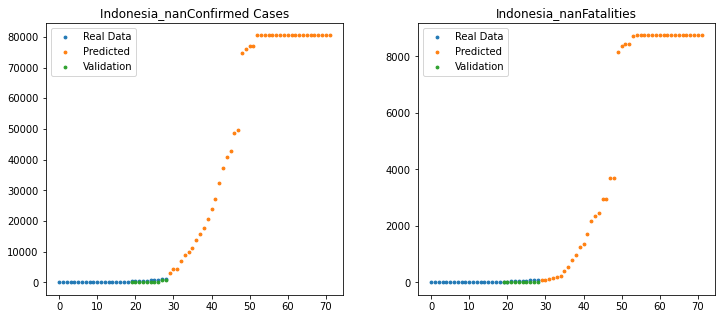

In [91]:
# Choose using region_ix
#region_ix = 3
#region = unique_region_list[region_ix]

# Choose using region
region = "Indonesia_nan"
region_ix = unique_region_list.index(region)

USE_LOG_SCALE=False
PLOT_LINE = False
##############################################

#mask = X["Region"]==region
mask = X_default["Region"] == region #Can use any X sets actually, since all the regions are the same 
N = Y[mask].shape[0]
x_ = np.arange(N+num_days_to_predict)

validation_confirmed_cases = Y_val_predicted_final[region_ix*num_validation_days:(region_ix+1)*num_validation_days,0]
validation_fatalities = Y_val_predicted_final[region_ix*num_validation_days:(region_ix+1)*num_validation_days,1]
predicted_confirmed_cases = Y_test_predicted_final[region_ix*num_days_to_predict:(region_ix+1)*num_days_to_predict,0]
predicted_fatalities = Y_test_predicted_final[region_ix*num_days_to_predict:(region_ix+1)*num_days_to_predict,1]

#Configuration and data preparation
sz = 8
grid_size = (1,2)
x_data = [[x_[:N], x_[N:], x_[N-num_validation_days:N]]] * 2
y_data = [[np.exp(Y[mask]["ConfirmedCases"]) - 1, predicted_confirmed_cases, validation_confirmed_cases], \
          [np.exp(Y[mask]["Fatalities"]) - 1, predicted_fatalities, validation_fatalities]]
labels = [["Real Data", "Predicted", "Validation"]] * 2
use_log_scale = [False, False]
grid_titles = [region + "Confirmed Cases", region + "Fatalities"]
if(PLOT_LINE):
    plot_type = "line"
else:
    plot_type= "scatter"

#Plot data in a grid
plot_grid_pyplot(grid_size, x_data, y_data, label_list=labels, log_usages=use_log_scale, grid_titles=grid_titles, plot_type="scatter")

In [92]:
print(predicted_confirmed_cases, region)

[ 2995.56867357  4337.75123064  4402.11317218  7094.19709094
  8927.02764828  9761.33866876 11201.07563348 13768.03131666
 15656.30329045 17641.15296177 20591.4779452  23861.7155243
 27267.68994718 32467.60145414 37296.78751363 40939.33168696
 42799.41078647 48580.05707691 49726.09768866 74698.27288197
 75883.34013863 77079.39255616 77156.66120331 80477.8625253
 80477.8625253  80477.8625253  80477.8625253  80477.8625253
 80477.8625253  80477.8625253  80477.8625253  80477.8625253
 80477.8625253  80477.8625253  80477.8625253  80477.8625253
 80477.8625253  80477.8625253  80477.8625253  80477.8625253
 80477.8625253  80477.8625253  80477.8625253 ] Indonesia_nan


Now, to compare with the results that were using other features as well:

In [93]:
validation_confirmed_list  = [Y_val_predicted_linearized[i][region_ix*num_validation_days:(region_ix+1)*num_validation_days,0] 
                                for i in range(0, len(Y_val_predicted_linearized))]
validation_fatalities_list = [Y_val_predicted_linearized[i][region_ix*num_validation_days:(region_ix+1)*num_validation_days,1]
                                for i in range(0, len(Y_val_predicted_linearized))]
predicted_confirmed_list   = [Y_test_predicted_linearized[i][region_ix*num_days_to_predict:(region_ix+1)*num_days_to_predict,0]
                                for i in range(0, len(Y_test_predicted_linearized))]
predicted_fatalities_list  = [Y_test_predicted_linearized[i][region_ix*num_days_to_predict:(region_ix+1)*num_days_to_predict,1]
                                for i in range(0, len(Y_test_predicted_linearized))]

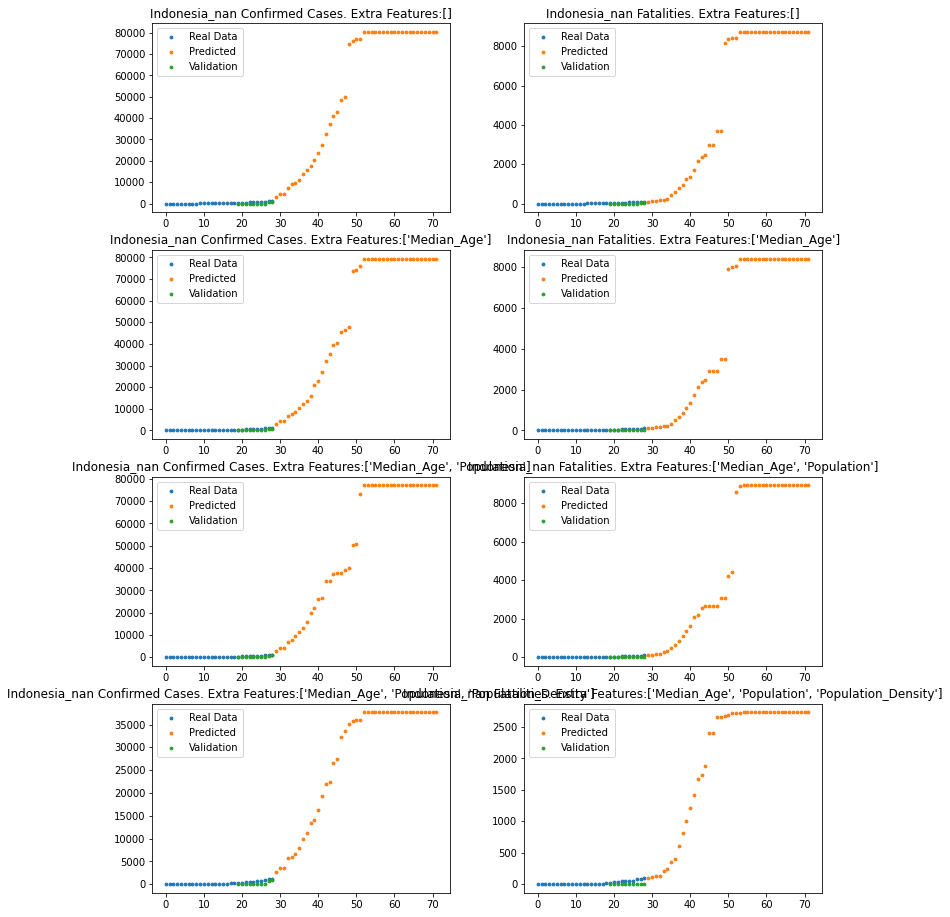

In [94]:
#Configuration and data preparation
sz = 8
grid_size = (4, 2)
x_data = [[x_[:N], x_[N:], x_[N-num_validation_days:N]]] * (grid_size[0] * grid_size[1])
y_data = [None] * (grid_size[0] * grid_size[1])
grid_titles = y_data.copy()
#grid_titles = [None] * grid
for i in range(0, len(predicted_confirmed_list)):
    y_data[2 * i] = [np.exp(Y[mask]["ConfirmedCases"]) - 1, predicted_confirmed_list[i], validation_confirmed_list[i]]
    y_data[2 * i + 1] = [np.exp(Y[mask]["Fatalities"]) - 1, predicted_fatalities_list[i], validation_fatalities_list[i]]
    grid_titles[2 * i] = region + " Confirmed Cases. Extra Features:" + str(extra_features_set[i])
    grid_titles[2 * i + 1] = region + " Fatalities. Extra Features:" + str(extra_features_set[i])
labels = [["Real Data", "Predicted", "Validation"]] * (grid_size[0] * grid_size[1])
use_log_scale = [False] * (grid_size[0] * grid_size[1])

plot_grid_pyplot(grid_size, x_data, y_data, label_list=labels, log_usages=use_log_scale, grid_titles=grid_titles, plot_type="scatter", figsize=(12, 16))


## DUMP PLAYGROUND

In [95]:
def get_unique_region_list(filename):
    df = pd.read_csv(filename)

    # Create category called Region: country_province
    region_list = ["{}_{}".format(df["Country_Region"][i], df["Province_State"][i]) for i in range(df.shape[0])]
    df["Region"]=region_list

    # Get first day of corona virus for each region
    unique_region_list = list(set(region_list))
    unique_region_list.sort()
    
    num_list = [np.sum(np.array(region_list)==region) for region in unique_region_list]
    return np.array(unique_region_list),np.array(num_list)

In [96]:
unique_region_list, unique_num_list = get_unique_region_list("data/train.csv")

In [97]:
unique_region_list

array(['Afghanistan_nan', 'Albania_nan', 'Algeria_nan', 'Andorra_nan',
       'Angola_nan', 'Antigua and Barbuda_nan', 'Argentina_nan',
       'Armenia_nan', 'Australia_Australian Capital Territory',
       'Australia_New South Wales', 'Australia_Northern Territory',
       'Australia_Queensland', 'Australia_South Australia',
       'Australia_Tasmania', 'Australia_Victoria',
       'Australia_Western Australia', 'Austria_nan', 'Azerbaijan_nan',
       'Bahamas_nan', 'Bahrain_nan', 'Bangladesh_nan', 'Barbados_nan',
       'Belarus_nan', 'Belgium_nan', 'Belize_nan', 'Benin_nan',
       'Bhutan_nan', 'Bolivia_nan', 'Bosnia and Herzegovina_nan',
       'Brazil_nan', 'Brunei_nan', 'Bulgaria_nan', 'Burkina Faso_nan',
       'Cabo Verde_nan', 'Cambodia_nan', 'Cameroon_nan', 'Canada_Alberta',
       'Canada_British Columbia', 'Canada_Manitoba',
       'Canada_New Brunswick', 'Canada_Newfoundland and Labrador',
       'Canada_Nova Scotia', 'Canada_Ontario',
       'Canada_Prince Edward Island'